### This is the test for data for punching standing agent according to its hp.

- Standing agent is P1, we are learning P2 (P2 is human player).

- Some frames will be removed, there are frames that;
    - Both players standing.
    - Consecutive ones(If frame's action is same with previous frame, it will be removed).
    - If we are(P2) in RECOV frame(Since we don't make RECOV frames ourselves).

### Importing libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib

# For using core package that located in the two upper folder.
import sys
sys.path.append('../../')

from core.json_importer import parse_json_file
from core.filters import remove_both_standing_frames, remove_same_consecutive_actions, remove_recov_frames
from core.actions import one_hot_encode, decode
from core.preproccessing import Normalizer
from core.helpers import write_file

Using TensorFlow backend.


In [2]:
# Open file
game_data = parse_json_file("data/punch_acc_hp.json")

### Pre process data

- In the pre process phase, we remove P2's datas from training set in order to crate labels. Labels are just actions of P2.

- We calculate the distance for each coordinate axis. (x distance, y distance)

- We also make actions one-hot encoding. 

- One-hot encoding for inputs and labels are not same. For example, Dash action in the input may have encoding [0,1] while Dash action in the label have encoding [0, 0, 1, 0].

- Integer values normalized. (P1-HP, P2-HP, X-Distance, Y-Distance)

- <font color='green'>There must be mechanism for understanding is player closing or move away.</font>

- There is no test and validation set preparation. Data that gathered from different rounds can be used for this problem.

- After pre-process we just have <font color='red'>[P1-Action, P1-HP, P2-HP, X-Distance, Y-Distance] -> P2-Action</font>

#### Remove unneeded frames

In [3]:
l1 = game_data.filter(remove_both_standing_frames)
l2 = game_data.filter(remove_same_consecutive_actions)
l3 = game_data.filter(remove_recov_frames)

print("Removed {} frames that both players are standing".format(l1))
print("Removed {} frames that have same consecutive actions".format(l2))
print("Removed {} frames that are recov frames".format(l3))
print("\n{} frames removed.".format(l1 + l2 + l3))
print("{} frames left.".format(len(game_data)))

Removed 1071 frames that both players are standing
Removed 9253 frames that have same consecutive actions
Removed 234 frames that are recov frames

10558 frames removed.
242 frames left.


#### Encoding and normalization

In [4]:
def normalize_and_save(data, file_name):
    p1_hp_normalizer = Normalizer()
    p1_normalized_hp = p1_hp_normalizer.normalize(data)
    p1_hp_normalizer.save("out/" + file_name)
    return p1_normalized_hp

## Pre process data
processed_data = []

# Create one hot encoding for actions (For input and labels)
p1_one_hot_encoded_actions = one_hot_encode(game_data.get_column("P1-action"))
labels = one_hot_encode(game_data.get_column("P2-action"))

# Normalize uncategorized features
p1_normalized_hp = normalize_and_save(game_data.get_column("P1-hp"), "p1_hp_norm.save")
p2_normalized_hp = normalize_and_save(game_data.get_column("P2-hp"), "p2_hp_norm.save")
normalized_x_distance = normalize_and_save([frame["P1-x"] - frame["P2-x"] for frame in game_data], "x_norm.save")
normalized_y_distance = normalize_and_save([frame["P1-y"] - frame["P2-y"] for frame in game_data], "y_norm.save")

for index in range(len(game_data)):    
    processed_row = []
    processed_row.extend(p1_one_hot_encoded_actions[index])
    processed_row.extend(p1_normalized_hp[index]) 
    processed_row.extend(p2_normalized_hp[index])
    processed_row.extend(normalized_x_distance[index])
    processed_row.extend(normalized_y_distance[index])
    
    processed_data.append(processed_row)
processed_data = np.array(processed_data)
labels = np.array(labels)

### Example data

In [5]:
EXAMPLE_ROW = 10

print("There are %d frames in dataset." % len(processed_data))
print("After pre processing the shape of our dataset is %s" % str(processed_data.shape))
print("\nOne example in index %d." % EXAMPLE_ROW)

row = processed_data[EXAMPLE_ROW]
print("\tProcessed Frame:" )
print("\t\tP1 Action(one-hot):\t%s" % row[0: 55])
print("\t\tP1 Hp(norm.):\t\t%s" % row[55])
print("\t\tP2 Hp(norm.):\t\t%s" % row[56])
print("\t\tX Dist(norm.):\t\t%s" % row[57])
print("\t\tY Dist(norm.):\t\t%s" % row[58])
print("\t\tLabel:\t\t\t%s" % labels[EXAMPLE_ROW])

There are 242 frames in dataset.
After pre processing the shape of our dataset is (242, 59)

One example in index 10.
	Processed Frame:
		P1 Action(one-hot):	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
		P1 Hp(norm.):		0.04926108374384236
		P2 Hp(norm.):		0.0
		X Dist(norm.):		0.11299435028248588
		Y Dist(norm.):		0.0
		Label:			[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


### Neural Network Design

Our neural network has two hidden layers in this test. They has 12 and 8 neurons respectively.

In [6]:
# Constants
INPUT_LAYER_SIZE = processed_data.shape[1]
OUTPUT_LAYER_SIZE = labels.shape[1]

In [7]:
model = Sequential()
model.add(Dense(12, input_dim=INPUT_LAYER_SIZE, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(OUTPUT_LAYER_SIZE, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Logging for tensorboard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [9]:
history = model.fit(processed_data, labels, epochs=150, validation_split=0.2,
                    shuffle=True, batch_size=10, callbacks=[tensorboard])
print('\tTraining ended.')

Train on 193 samples, validate on 49 samples
Epoch 1/150
193/193 [==============================] - 0s 1ms/step - loss: 4.0083 - acc: 0.0052 - val_loss: 3.9845 - val_acc: 0.0000e+00
Epoch 2/150
193/193 [==============================] - 0s 353us/step - loss: 3.9463 - acc: 0.0933 - val_loss: 3.9288 - val_acc: 0.0000e+00
Epoch 3/150
193/193 [==============================] - 0s 279us/step - loss: 3.8762 - acc: 0.2798 - val_loss: 3.8599 - val_acc: 0.0000e+00
Epoch 4/150
193/193 [==============================] - 0s 285us/step - loss: 3.7732 - acc: 0.2798 - val_loss: 3.7421 - val_acc: 0.0000e+00
Epoch 5/150
193/193 [==============================] - 0s 281us/step - loss: 3.6044 - acc: 0.2798 - val_loss: 3.5470 - val_acc: 0.0000e+00
Epoch 6/150
193/193 [==============================] - 0s 358us/step - loss: 3.3342 - acc: 0.2798 - val_loss: 3.2241 - val_acc: 0.0000e+00
Epoch 7/150
193/193 [==============================] - 0s 308us/step - loss: 2.9198 - acc: 0.2798 - val_loss: 2.7536 - val_

Epoch 61/150
193/193 [==============================] - 0s 272us/step - loss: 0.7233 - acc: 0.7409 - val_loss: 0.4804 - val_acc: 0.8163
Epoch 62/150
193/193 [==============================] - 0s 381us/step - loss: 0.7161 - acc: 0.7720 - val_loss: 0.4710 - val_acc: 0.8571
Epoch 63/150
193/193 [==============================] - 0s 469us/step - loss: 0.7091 - acc: 0.7772 - val_loss: 0.4585 - val_acc: 0.8776
Epoch 64/150
193/193 [==============================] - 0s 428us/step - loss: 0.7020 - acc: 0.7772 - val_loss: 0.4525 - val_acc: 0.8571
Epoch 65/150
193/193 [==============================] - 0s 334us/step - loss: 0.6934 - acc: 0.8031 - val_loss: 0.4452 - val_acc: 0.8980
Epoch 66/150
193/193 [==============================] - 0s 274us/step - loss: 0.6870 - acc: 0.7876 - val_loss: 0.4457 - val_acc: 0.8367
Epoch 67/150
193/193 [==============================] - 0s 290us/step - loss: 0.6786 - acc: 0.7927 - val_loss: 0.4347 - val_acc: 0.8980
Epoch 68/150
193/193 [==========================

193/193 [==============================] - 0s 325us/step - loss: 0.4401 - acc: 0.9378 - val_loss: 0.2244 - val_acc: 1.0000
Epoch 122/150
193/193 [==============================] - 0s 300us/step - loss: 0.4421 - acc: 0.9275 - val_loss: 0.2267 - val_acc: 1.0000
Epoch 123/150
193/193 [==============================] - 0s 339us/step - loss: 0.4378 - acc: 0.9275 - val_loss: 0.2208 - val_acc: 0.9796
Epoch 124/150
193/193 [==============================] - 0s 302us/step - loss: 0.4339 - acc: 0.9378 - val_loss: 0.2170 - val_acc: 0.9796
Epoch 125/150
193/193 [==============================] - 0s 309us/step - loss: 0.4341 - acc: 0.9275 - val_loss: 0.2178 - val_acc: 1.0000
Epoch 126/150
193/193 [==============================] - 0s 305us/step - loss: 0.4313 - acc: 0.9326 - val_loss: 0.2174 - val_acc: 0.9796
Epoch 127/150
193/193 [==============================] - 0s 436us/step - loss: 0.4284 - acc: 0.9326 - val_loss: 0.2111 - val_acc: 1.0000
Epoch 128/150
193/193 [==============================] 

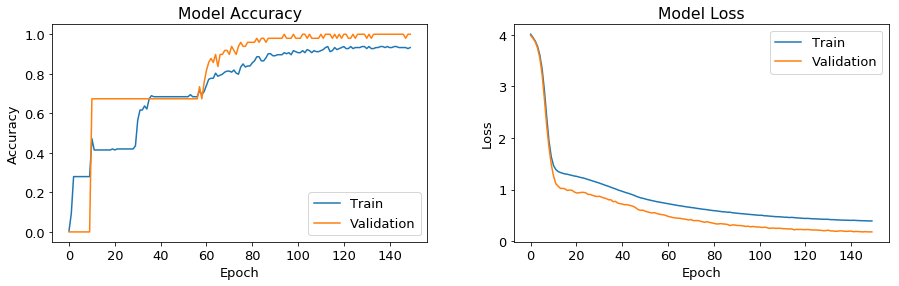

In [30]:
font = {'size'   : 13}
matplotlib.rc('font', **font)

def plot_history(history):
    fig = plt.figure(figsize=(15, 4))
    fig.subplots_adjust(wspace=0.23)
    # summarize history for accuracy
    acc = fig.add_subplot(1, 2, 1)
    acc.plot(history.history['acc'])
    acc.plot(history.history['val_acc'])
    acc.set_title('Model Accuracy')
    acc.set_ylabel('Accuracy')
    acc.set_xlabel('Epoch')
    acc.legend(['Train', 'Validation'], loc='lower right')
    # summarize history for loss
    loss = fig.add_subplot(1, 2, 2)
    loss.plot(history.history['loss'])
    loss.plot(history.history['val_loss'])
    loss.set_title('Model Loss')
    loss.set_ylabel('Loss')
    loss.set_xlabel('Epoch')
    loss.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
plot_history(history)